# Empirical Evaluation of the Quantum Nostradamus Attack on a Toy Hashfunction

## 1. Introduction

This notebook empirically evaluates the quantum attacks proposed by Barbara Jiabao Benedikt in her work "*Nostradamus-Angriff auf Hashfunktionen mittels Quantenalgorithmen*" [[1]]() in the context of a toy hash function based on a Sponge construction.

Throughout this notebook, we use the Python SDK Qiskit for the implementation and execution of quantum circuits. Qiskit is beneficial due to the practical component this SDK provides. Next to the quantum computer simulations that we use in this notebook, Qiskit also provides access to real-world quantum computers. Even though these machines are relatively error-prone, a practical evaluation provides additional information on the practicability of a quantum attack. In contrast, competitors such as Google Cirq do currently not offer real-world execution but instead have different strengths, such as more complex operations for Quantum Machine Learning.

The rest of the notebook is organized as follows: In the first section (2), the toy hash function is presented and implemented in a quantum circuit. In contrast to a classical implementation, a quantum circuit of the function may give an attacker superposition access, which is required for the proposed attacks. A simple quantum attack with Grover's algorithm is implemented in section (3.1). The latter sections (3.2 and 3.3) document the implementation of the Nostradamus quantum attack and a further improved version of said algorithm. The evaluation of the algorithms is the topic of the final section (4) in this notebook. 

## 2. A Quantum Toy Hash Function based on the Sponge Construction

To apply the proposed attack in [[1]]() on a hash function, the function needs to fulfill certain requirements:
1. The hash function needs to be iterative. This is achieved securely with a Sponge construction.
2. The round or compression function of the hash function needs to have a (relatively small) finite domain to limit the number of qubits required for its simulation. Indeed, we could use up to at most ~30 qubits for any simulated quantum circuit.
3. The round or compression function of the hash function needs to be "well distributing". This property is targeted by constructing the function with a simplified version of the Chacha permutation. Note that this method of construction is similar to the approach in [[2]](https://github.com/qiboteam/qibo/tree/master/examples/hash-grover).

### 2.1 Classical Construction of the Hash Toy Function

Due to the limitations of a quantum simulator with at max ~30 qubits, we construct the following reduced form of the cipher based on [[2]](https://github.com/qiboteam/qibo/tree/master/examples/hash-grover). But first, we provide some parameters for hash function manipulation and some performance metrics for the final evaluation.

In [1]:
# constants for manipulating the toy hash function

# size of a message and hash function (also B)
# n % 3 == 0 && n >= 6
n = 6

# number of loops for each round function
r = 10

# register length 
reg_len = int(n/3)

# length padding 
len_pad = True

# ghost variables 
# counts the function calls 
ghost_cfunction_calls_round = 0
ghost_qfunction_calls_round = 0
ghost_qfunction_calls_fcol = 0
ghost_qfunction_calls_fcon = 0
# counts the number of times Grover's algorithm needs to be repeated
ghost_grover_repititions = 0
# counts of samples 
ghost_sampling = 0
# time measurments
ghost_pre_time = 0
ghost_after_time = 0

In [2]:
def ghost_init():
     """Resets all ghost variables."""
     global ghost_cfunction_calls_round, ghost_qfunction_calls_round, ghost_grover_repititions, ghost_qfunction_calls_fcol, ghost_qfunction_calls_fcon, ghost_sampling, ghost_pre_time, ghost_after_time
     ghost_cfunction_calls_round = 0
     ghost_qfunction_calls_round = 0
     ghost_qfunction_calls_fcol = 0
     ghost_qfunction_calls_fcon = 0
     ghost_grover_repititions = 0
     ghost_sampling = 0
     ghost_pre_time = 0
     ghost_after_time = 0

In [3]:
def print_ghost_variables():
    """This algorithm prints all the ghost variables from an attack.
    """
    print("In the previous attack:")
    print("A hash function with size n={} and B={} was attacked.".format(n, n))
    print("The pre calculation took {} seconds.".format(ghost_pre_time))
    print("The after calculation took {} seconds.".format(ghost_after_time))
    print("Therefore the total took {} seconds.".format(ghost_pre_time + ghost_after_time))
    print("{} classical round function calls were required.".format(ghost_cfunction_calls_round))
    print("{} quantum round function calls were required.".format(ghost_qfunction_calls_round))
    print("{} quantum function calls to F_collision were required.".format(ghost_qfunction_calls_fcol))
    print("{} quantum function calls to F_connection were required.".format(ghost_qfunction_calls_fcon))
    print("{} Grover repitions were required.".format(ghost_grover_repititions))
    print("{} Values were sampled.".format(ghost_sampling))

Next, we implement the reduced equivalent of a quarter round in the ChaCha permutation. The quarter round permutes the bits within two register (A and B) with xor, add and rotation operations. 

In [4]:
from bitstring import BitArray

def chacha_qr(A, B):
    """Classical implementation of a reduced Chacha quarter round
    Args:
        A (str): classical bitstring for a site of the permutation matrix.
        B (str): classical bitstring for a site of the permutation matrix.     
    Returns:
        A (str): updated classical bitstring for a site of the permutation matrix.
        B (str): updated classical bitstring for a site of the permutation matrix.
    """
    # register length determines rotations 
    rot = list(range(1, reg_len))
    rot += [1]

    # iterations within one quarter round are dependent on list of rotations 
    for r in range(len(rot)):

        sum_result = (A.uint + B.uint) % 2**reg_len
        A = BitArray(uint=sum_result, length=reg_len)

        # xor 
        B ^= A

        # (cyclic) rotate B to the left
        B.rol(rot[r])

    return A, B

Now, we construct the round function of our hash construction. Each round function applies the quarter rounds multiple times on every combination of registers (A, B, C) to permute the contained bits.

In [5]:
def chash_round(m, A, B, C):
    """Classical implementation of a reduced Chacha round function
    Args:
        m (BitString): classical bitstring for a message of size B.
        A (str): classical bitstring for a site of the permutation matrix.
        B (str): classical bitstring for a site of the permutation matrix.
        C (str): classical bitstring for a site of the permutation matrix.    
    Returns:
        A (str): updated classical bitstring for a site of the permutation matrix.
        B (str): updated classical bitstring for a site of the permutation matrix.
        C (str): updated classical bitstring for a site of the permutation matrix.
    """
    global ghost_cfunction_calls_round
    ghost_cfunction_calls_round = ghost_cfunction_calls_round + 1

    # sponge construction
    A = A ^ m[:reg_len]
    B = B ^ m[reg_len:2*reg_len]
    C = C ^ m[2*reg_len:]

    # round function
    for i in range(r):
        A, C = chacha_qr(A, C)
        B, C = chacha_qr(B, C)
        A, B = chacha_qr(A, B)

    return A, B, C

And finally, we implement the complete (classical) hash algorithm for an arbitrary amount of rounds. Note that we optionally use a slighlty different form of length padding compared to SHA256, where 1 is followed by b zeros and a an encoding of the length |m|.

In [6]:
def chash(message, q=2, IV_1=1, IV_2=3, length_padding=True):
    """Calulates the hash according to a reduced ChaCha permutation and is based on the Sponge construction.
    Args:
        message (BitArray): message of arbitrary size (but modulo n) that is hashed.
        q (int): number of bits in each bitstring.
        IV_1 (int): IV for parameter b of hash function
        IV_2 (int): IV for parameter c of hash function
        length_padding (bool): length padding enabled?
    Returns:
       The hash of the message according to a reduced ChaCha permutation.
    """
    # copy to prevent overwriting 
    message = BitArray(message)

    # length padding 
    if length_padding:

        # remember length mod 5
        m_len = len(message)
        m_len = m_len % 5

        # append 1
        message += BitArray(bin='1')

        # calculate b
        rest = (len(message) + 1 + 4) % n
        b = -rest % n
        b = b + 1

        # append b zeros 
        message += BitArray(bin=b*'0')

        # append 4-bit len
        message += BitArray(bin=(4-m_len)*'0' + m_len *'1')   

    # construct list of message blocks
    message_blocks = list(message.cut(n))
    
    # create ChaCha parameters
    a = BitArray(uint=0, length=reg_len)
    b = BitArray(uint=0, length=reg_len)
    c = BitArray(uint=0, length=reg_len)

    # initalization message
    a_init = BitArray(uint=0, length=reg_len)
    b_init = BitArray(uint=IV_1, length=reg_len)
    c_init = BitArray(uint=IV_2, length=reg_len)

    m_init = a_init + b_init + c_init

    # first double round
    a, b, c = chash_round(m_init, a, b, c)

    # sponge construction and second double round
    m1 = message_blocks[0]        
    a, b, c = chash_round(m1, a, b, c)

    # hash function optionally works for more blocks of messages
    for m in message_blocks[1:]:

            # next double round     
            a, b, c = chash_round(m, a, b, c)
    
    # the hash is constructed from the concatenation of A, B and C
    return a + b + c

Let's test our classical construction on a bitstring.

In [7]:
binary = BitArray(bin=n*'1') 
print("H({}) = {}".format(binary.bin, chash(binary, length_padding=len_pad).bin))

H(111111) = 011110


... and a bitstring double the size.

In [8]:
# concatenate binary
double_binary = 2 * binary
print("H({}) = {}".format(double_binary.bin, chash(double_binary, length_padding=len_pad).bin))

H(111111111111) = 110111


And also let's test a bitstring for which length padding is required, if enabled.

In [9]:
if len_pad:
    binary_pad = BitArray(bin=(n+1)*'1') 
    print("H({}) = {}".format(binary_pad.bin, chash(binary_pad, length_padding=len_pad).bin))

H(1111111) = 111101


### 2.2 Evaluation of the Regularity of the Toy Hash Function

As mentioned before, the round function needs to achieve a good distribution. Indeed, a well-suited round function is regular: Every image has a similar number of preimages. The regularity of the round function can be evaluated by counting the number of inputs that map on each output.

In [10]:
# start of preimage calculation
preimage_counts = [0] * 2**(n)

# init IV
a_bin = BitArray(bin=reg_len*'0')
b_bin = BitArray(bin=reg_len*'1')
c_bin = BitArray(bin=reg_len*'0')

# count the number of preimages for every image 
# for every message 
for m in range(2**n):
    message = BitArray(uint=m, length=n)

    a_n, b_n, c_n = chash_round(message, a_bin, b_bin, c_bin)

    res = a_n + b_n + c_n 

    goal = BitArray(bin='000101')

    preimage_counts[res.uint] = preimage_counts[res.uint] + 1

print(preimage_counts)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### 2.3 Quantum Construction of the Hash Toy Function

Now that we constructed our classical hash function, we can transition to the quantum domain. For our attacks and specifically Grover's algorithm to work, we need to construct a circuit that enables function access in superposition (QS2). This can be achieved with the following design for a quantum quarter round.

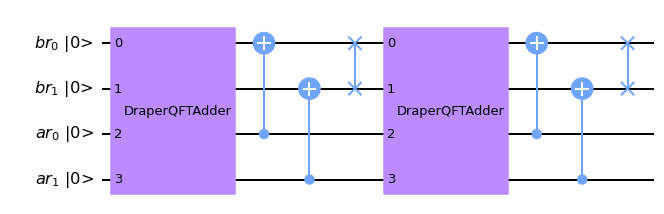

In [11]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library.arithmetic.adders import DraperQFTAdder

def construct_qr_gate(reg_len):
    """Construction of the Gate for the qr function. 
    Args:
        n (int): size of a message and hash function (also B).    
        reg_len (int): register length.   
    Returns:
        hash_gate (Quantum Gate): The Gate for the qr function.
        img (Image): Image of the quantum circuit.
    """ 
    ar_qr = QuantumRegister(reg_len, 'ar')
    br_qr = QuantumRegister(reg_len, 'br')

    # create a circuit
    chacha_qqr = QuantumCircuit(br_qr, ar_qr)

    # create adder (mod 2**n) gate
    add_gate = DraperQFTAdder(reg_len).to_gate()

    # register length determines rotations 
    rot = list(range(1, reg_len))
    rot += [1]

    # construct circuit
    for r in range(len(rot)):

        # append add gate
        chacha_qqr.append(add_gate, [*range(2*reg_len)])

        # append xor operation
        chacha_qqr.cnot(ar_qr, br_qr)

        # append rotation
        for i in range(rot[r]):
            for j in reversed(range(reg_len-1)):
                chacha_qqr.swap(j+1,j)

    # convert to quantum gate
    qr_gate = chacha_qqr.to_gate(label='QR')

    # draw circuit
    img = chacha_qqr.draw(output='mpl', initial_state=True)

    return qr_gate, img

# application 
qr_gate, img = construct_qr_gate(reg_len)
img

Note that this circuit works exactly like our classical implementation of the quarter round. Next, let's assemble the quarter rounds to a quantum round function of the toy hash function.

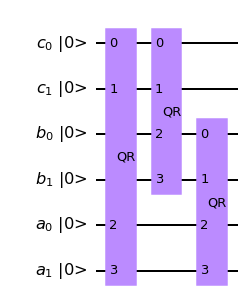

In [12]:
def construct_round_gate(n, reg_len):
    """Construction of the Gate for the round function. 
    Args:
        n (int): size of a message and hash function (also B).    
        reg_len (int): register length.   
    Returns:
        hash_gate (Quantum Gate): The Gate for the round function.
        img (Image): Image of the quantum circuit.
    """ 
    a_qr = QuantumRegister(reg_len, 'a')
    b_qr = QuantumRegister(reg_len, 'b')
    c_qr = QuantumRegister(reg_len, 'c')

    # create a circuit for a double round
    chacha_qdr = QuantumCircuit(c_qr, b_qr, a_qr)

    #a, c = chacha_qr(a, c)
    chacha_qdr.append(qr_gate, list(c_qr) + list(a_qr))

    #b, c = chacha_qr(b, c)
    chacha_qdr.append(qr_gate, list(c_qr) + list(b_qr))

    #a, b = chacha_qr(a, b)
    chacha_qdr.append(qr_gate, list(b_qr) + list(a_qr))

    # convert to quantum gate
    dr_gate = chacha_qdr.to_gate(label='DR')

    # transfer in ten rounds
    # apply ten rounds
    chacha_qround = QuantumCircuit(c_qr, b_qr, a_qr)

    for i in range(r):
        chacha_qround.append(dr_gate, [*range(n)])

    round_gate = chacha_qround.to_gate(label='10_DR')

    # draw circuit
    img = chacha_qdr.draw(output='mpl', initial_state=True)

    return round_gate, img

# application 
round_gate, img = construct_round_gate(n, reg_len)
img

Once again, this implementation works just like the classical round function. We continue by constructing the whole hash function's circuit.

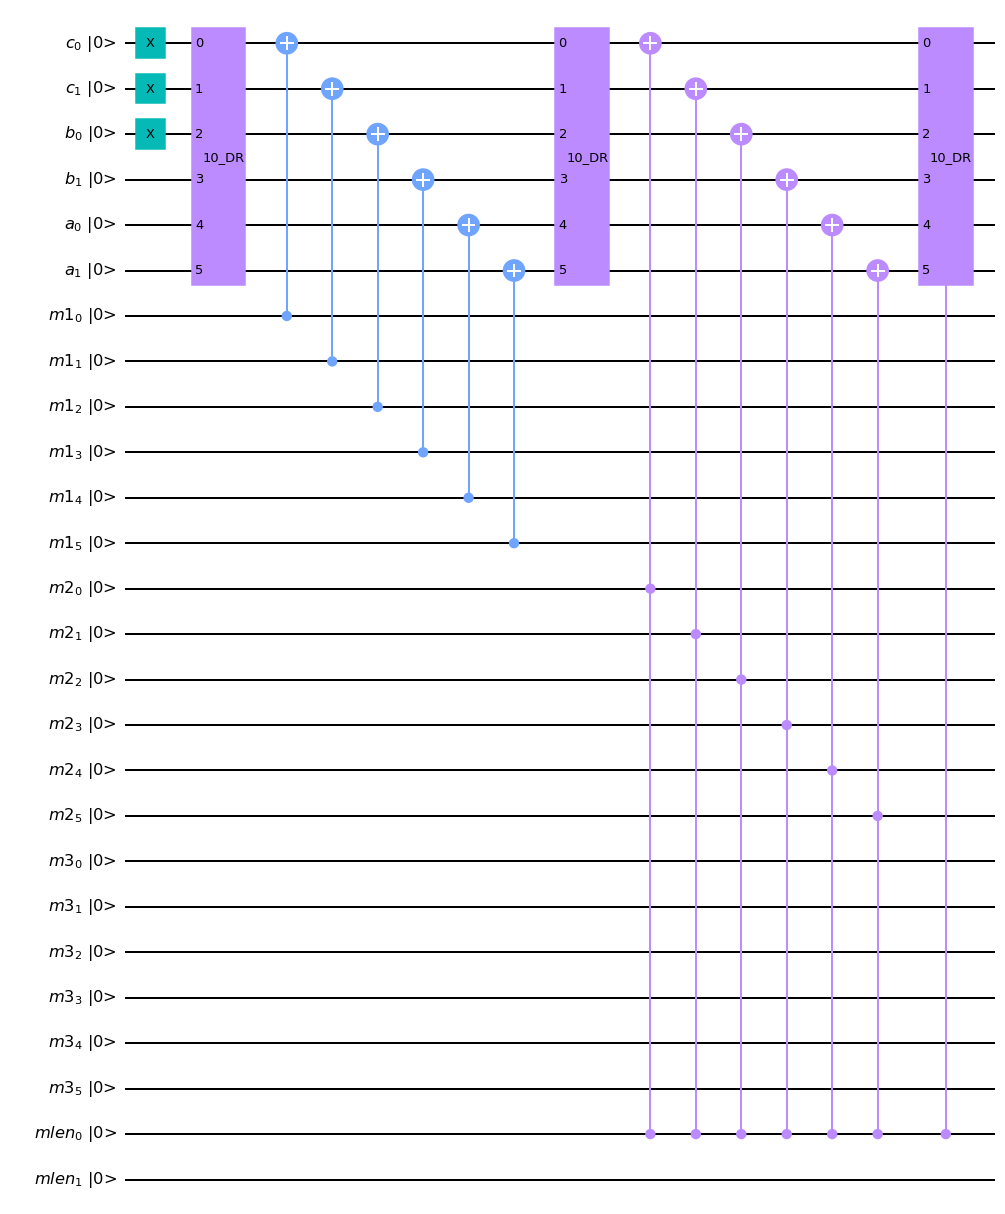

In [13]:
def construct_hash_gate(n, reg_len):
    """Construction of the Gate for the hash function. 
    Args:
        n (int): size of a message and hash function (also B).    
        reg_len (int): register length.   
    Returns:
        hash_gate (Quantum Gate): The Gate for the hash function.
        img (Image): Image of the quantum circuit.
    """ 
    a_qr = QuantumRegister(reg_len, 'a')
    b_qr = QuantumRegister(reg_len, 'b')
    c_qr = QuantumRegister(reg_len, 'c')
    m1_qr = QuantumRegister(n, 'm1')
    m2_qr = QuantumRegister(n, 'm2')
    m3_qr = QuantumRegister(n, 'm3')
    mlen_qr = QuantumRegister(2, 'mlen')

    # create a circuit
    chacha_hash = QuantumCircuit(c_qr, b_qr, a_qr, m1_qr, m2_qr, m3_qr, mlen_qr)

    # init registers with constant_1=1, constant_2=3
    # b = BitArray(uint=constant_1, length=reg_len)
    IV_temp = BitArray(uint = 1, length=reg_len)
    IV_temp.reverse()
    for i, bit in enumerate(IV_temp):
        if bit == 1:
            chacha_hash.x(i + reg_len)
        
    # c = BitArray(uint=constant_2, length=reg_len)
    IV_temp = BitArray(uint = 3, length=reg_len)
    IV_temp.reverse()
    for i, bit in enumerate(IV_temp):
        if bit == 1:
            chacha_hash.x(i)

    # apply r rounds
    chacha_hash.append(round_gate, [*range(n)])

    # sponge construction
    chacha_hash.cnot(m1_qr, [*range(n)])

    # apply r rounds
    chacha_hash.append(round_gate, [*range(n)])

    # controlled gate for the optional rounds
    round_gate_controlled = round_gate.control()

    # sponge construction: xor (optional) up to two more blocks of messages
    # for n > 6 only one testable!
    for m in range(1):

        # current qubit index
        qu = (m+2) * 3 * reg_len

        # current control qubit index
        cb = 12 * reg_len + m 

        # apply toffili gates 
        for i in range(qu,qu+n):
            chacha_hash.toffoli(cb, i, i-qu)

        # next double round  
        chacha_hash.append(round_gate_controlled, [cb] + [*range(n)]) 

    # convert to quantum gate
    hash_gate = chacha_hash.to_gate(label='hash')

    # draw circuit
    img = chacha_hash.draw(output='mpl', initial_state=True)

    return hash_gate, img

# application 
hash_gate, img = construct_hash_gate(n, reg_len)
img

#### 2.4 Testing of the Quantum Toy Hash Function

Last but not least, we need to measure the outcome of the hash gate to verify its correctness. Ideally, it should return the exact hash for our two binary values of different sizes that our classical implementation returned previously. For this purpose, we construct two test circuits that test the outcome for each of the two values. Let's begin with the small value.

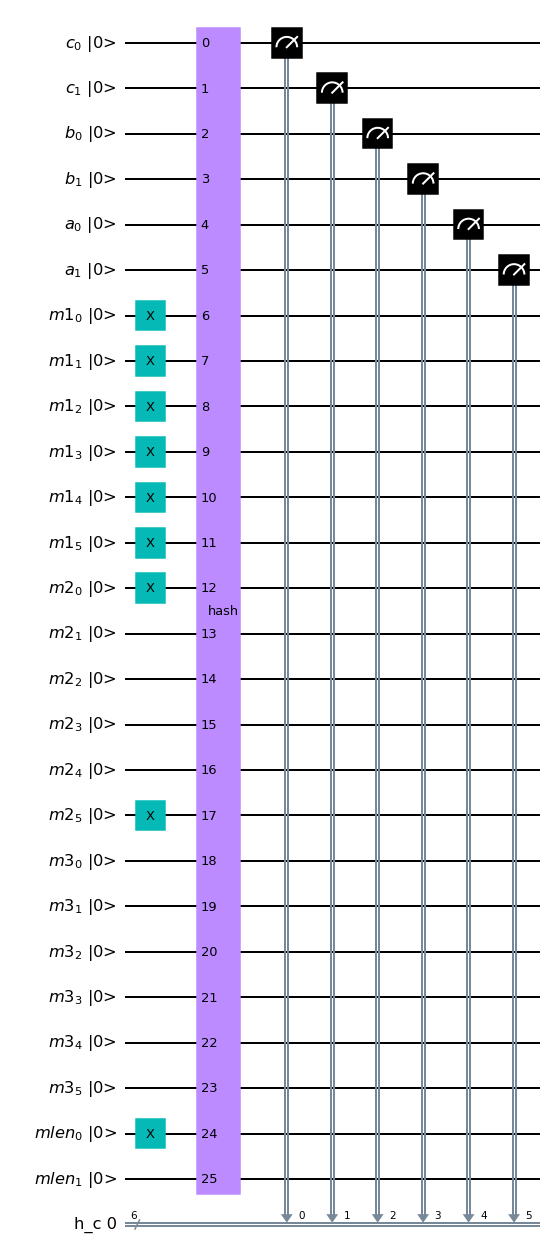

In [14]:
from qiskit import ClassicalRegister
a_qr = QuantumRegister(reg_len, 'a')
b_qr = QuantumRegister(reg_len, 'b')
c_qr = QuantumRegister(reg_len, 'c')
m1_qr = QuantumRegister(n, 'm1')
m2_qr = QuantumRegister(n, 'm2')
m3_qr = QuantumRegister(n, 'm3')
mlen_qr = QuantumRegister(2, 'mlen')

# construct a circuit for test purposes
h_cr = ClassicalRegister(n, 'h_c')
test_circuit_small = QuantumCircuit(c_qr, b_qr, a_qr, m1_qr, m2_qr, m3_qr, mlen_qr, h_cr)

# init m1: binary
test_circuit_small.x(m1_qr)

if len_pad:
    # init pad 
    m_len = n % 5
    pad = BitArray(bin='10' + (4-m_len) * '0' + m_len * '1')

    IV_temp = BitArray(pad)
    IV_temp.reverse()
    for i, bit in enumerate(IV_temp):
        if bit == 1:
            test_circuit_small.x(m2_qr[i])

    # init m_len
    test_circuit_small.x(mlen_qr[0])

# apply gate
test_circuit_small.append(hash_gate,[*range(4*n+2)])

# measure outcome
test_circuit_small.measure([*range(n)], h_cr)

# draw circuit
test_circuit_small.draw(output='mpl', initial_state=True)

Let's begin a simulation.

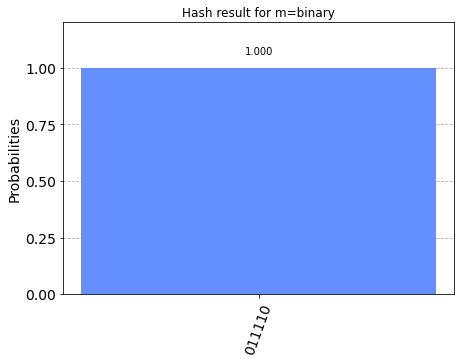

In [15]:
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram

simulator = Aer.get_backend('qasm_simulator')

result = execute(test_circuit_small, simulator, shots=2**n).result()
counts = result.get_counts(test_circuit_small)
plot_histogram(counts, title='Hash result for m=binary')

For comparison: 

In [16]:
print("H({}) = {}".format(binary.bin, chash(binary, length_padding=len_pad).bin))

H(111111) = 011110


Success!

Let's continue by testing our hash function on a value double the size. However, we will not test the length padding feature here and thus temporarily disable it for this test.

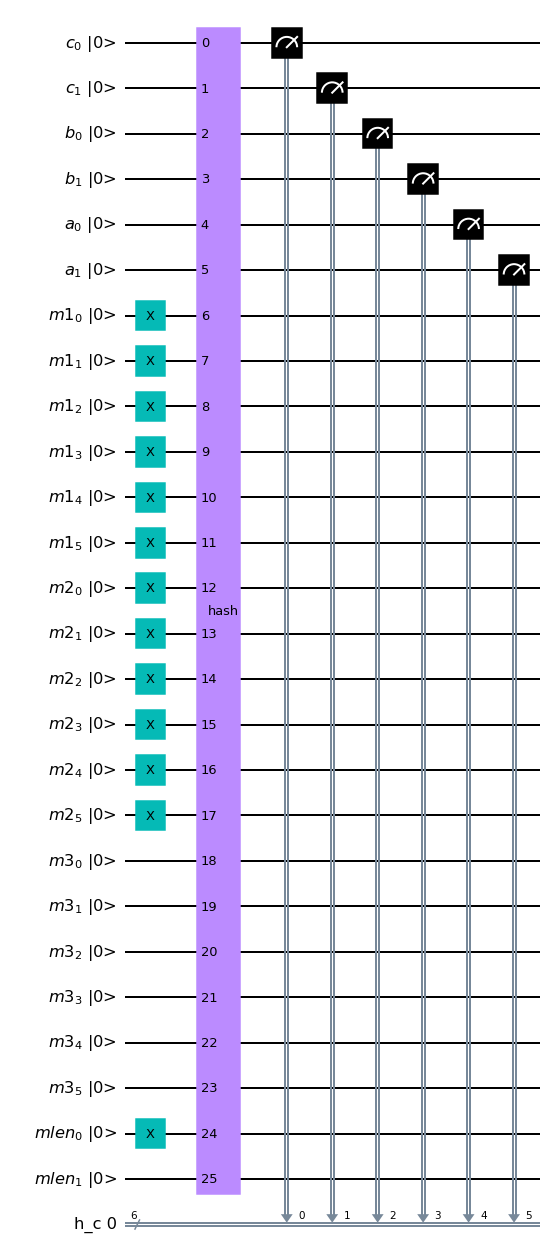

In [17]:
from qiskit import ClassicalRegister
# construct a circuit for test purposes
test_circuit_big = QuantumCircuit(c_qr, b_qr, a_qr, m1_qr, m2_qr, m3_qr, mlen_qr, h_cr)

# init m1: binary
test_circuit_big.x(m1_qr)

# init m2: binary
test_circuit_big.x(m2_qr)

# init mlen: 1
test_circuit_big.x(mlen_qr[0])

# apply gate
test_circuit_big.append(hash_gate,[*range(4*n+2)])

# measure outcome
test_circuit_big.measure([*range(n)], h_cr)

# draw circuit
test_circuit_big.draw(output='mpl', initial_state=True)

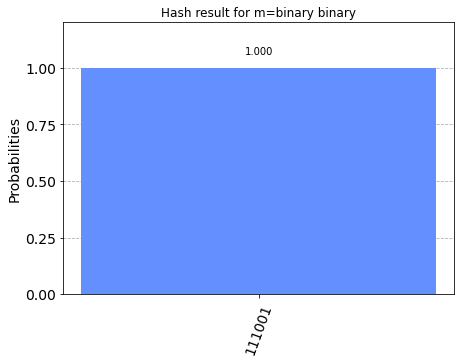

In [18]:
result = execute(test_circuit_big, simulator, shots=2**n).result()
counts = result.get_counts(test_circuit_big)
plot_histogram(counts, title='Hash result for m=binary binary')

For comparison: 

In [19]:
print("h*({}) = {}".format(double_binary.bin, chash(double_binary, length_padding=False).bin))

h*(111111111111) = 111001


### 2.5 Application of Grover on Toy Hash (Round) Function

We now apply Grover's algorithm on our toy round function for preimage search. This is mainly done to construct all the functionality required in the attacks of the next sections. 

Grover's algorithm works in two steps: Phase-Flip and Diffusion. These two steps are repeated a total number of sqrt(N) times, where N is the size of the function's domain. So, in other words, the algorithm achieves a quadratic speedup against the best-known classical algorithm. Furthermore, it has been shown that the algorithm is optimal in the sense that any quantum algorithm would at least need sqrt(N) queries to solve the underlying search problem [[3]](https://doi.org/10.1137%2Fs0097539796300933). 

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b9/Grover%27s_algorithm_circuit.svg" alt="drawing" width="600" />

[Grover's Algorithm Circuit](https://upload.wikimedia.org/wikipedia/commons/b/b9/Grover%27s_algorithm_circuit.svg)

The Phase-Flip operation works as follows.

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/07fb23bffa787430b084971c6a108a8f6ff6c2b3" alt="drawing" width="400" />

[Grover's Phase-Flip](https://wikimedia.org/api/rest_v1/media/math/render/svg/07fb23bffa787430b084971c6a108a8f6ff6c2b3)

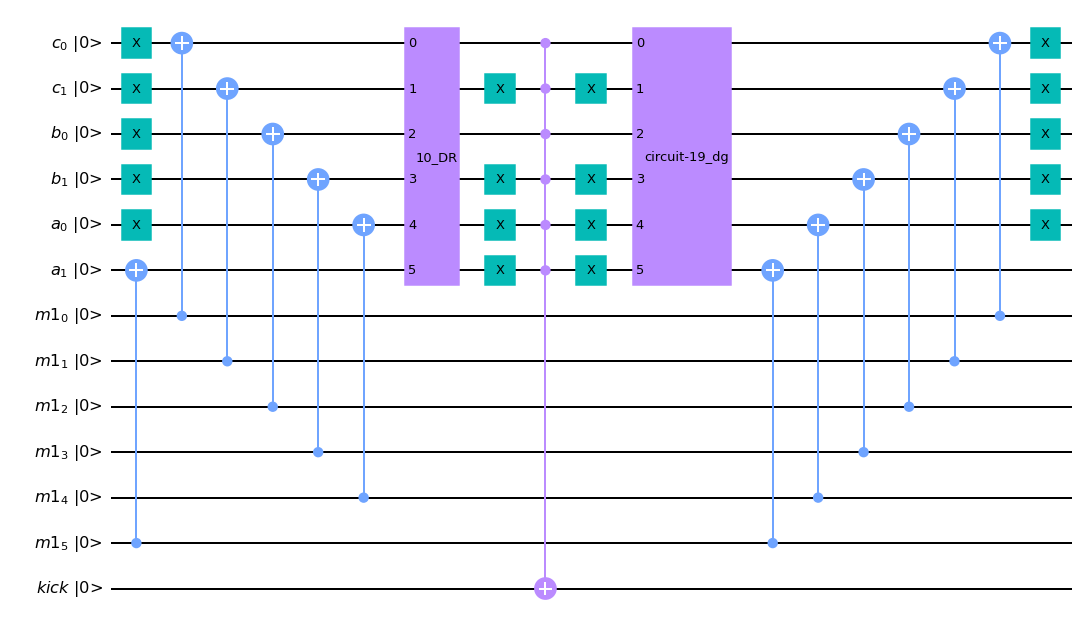

In [20]:
kickback_qr = QuantumRegister(1, 'kick')

def construct_flip_gate(H, IV):
    """Construction of the Phase Flip Operator for the chash_round function. 
    Args:
        H (BitArray): classical bitstring of the image.  
        IV (BitArray): classical bitstring that represents the IV of chash_round. 
    Returns:
        flip_gate (Quantum Gate): Phase Flip Operator for chash_round.
        img (Image): Image of the quantum circuit
    """ 
    a_qr = QuantumRegister(reg_len, 'a')
    b_qr = QuantumRegister(reg_len, 'b')
    c_qr = QuantumRegister(reg_len, 'c')
    m1_qr = QuantumRegister(n, 'm1')

    phase_flip = QuantumCircuit(c_qr, b_qr, a_qr, m1_qr, kickback_qr)
    phase_flip_side = QuantumCircuit(c_qr, b_qr, a_qr, m1_qr, kickback_qr)

     # initialize circuit according to IV
    IV_temp = BitArray(IV)
    IV_temp.reverse()
    for i, bit in enumerate(IV_temp):
        if bit == 1:
            phase_flip_side.x(i)

    # sponge construction
    phase_flip_side.cnot(m1_qr, [*range(n)])

    # apply chash_round
    phase_flip_side.append(round_gate,[*range(n)])

    # calculate specific controlled gate for preimage H
    H_tmp = BitArray(H)
    H_tmp.reverse()
    for i, bit in enumerate(H_tmp):
        if bit == 0:
            phase_flip_side.x(i)
    
    # apply all above operations to quantum circuit
    phase_flip.compose(phase_flip_side, inplace=True)

    # phase flip multi-cnot
    phase_flip.mct([*range(len(H))], kickback_qr)

    # apply the inverse of all above operations to quantum circuit
    phase_flip.compose(phase_flip_side.inverse(), inplace=True)

    # convert to quantum gate
    flip_gate = phase_flip.to_gate(label='chash_flip')

    # draw circuit
    img = phase_flip.draw(output='mpl', initial_state=True)

    return flip_gate, img

# application and illustration
H = BitArray(bin=(n-6) *'0') + BitArray(bin='000101')
IV = BitArray(bin=(n-6) *'0') + BitArray(bin='011111')
flip_gate, img = construct_flip_gate(H, IV)
img

The Diffusion operator works as follows.

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/07fb23bffa787430b084971c6a108a8f6ff6c2b3" alt="drawing" width="300" />

[Grover's Diffusion](https://wikimedia.org/api/rest_v1/media/math/render/svg/07fb23bffa787430b084971c6a108a8f6ff6c2b3)

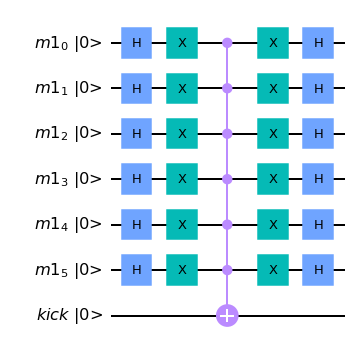

In [21]:
def construct_diffusion_gate():
    """Construction of the Diffusion Operator for the chash_round function. 
    Returns:
        diffusion_gate (Quantum Gate): Diffusion Operator for chash_round.
        img (Image): Image of the quantum circuit
    """ 
    m1_qr = QuantumRegister(n, 'm1')

    diffusion_circuit = QuantumCircuit(m1_qr, kickback_qr)

    # apply gates
    diffusion_circuit.h([*range(diffusion_circuit.num_qubits-1)])
    diffusion_circuit.x([*range(diffusion_circuit.num_qubits-1)])
    diffusion_circuit.mct([*range(diffusion_circuit.num_qubits-1)], kickback_qr)
    diffusion_circuit.x([*range(diffusion_circuit.num_qubits-1)])
    diffusion_circuit.h([*range(diffusion_circuit.num_qubits-1)])

    # convert to quantum gate
    diffusion_gate = diffusion_circuit.to_gate(label='diff')

    # draw circuit
    img = diffusion_circuit.draw(output='mpl', initial_state=True)

    return diffusion_gate, img

# application and illustration
diffusion_gate, img = construct_diffusion_gate()
img 

Eventually, we implement the complete circuit and start a simulation.

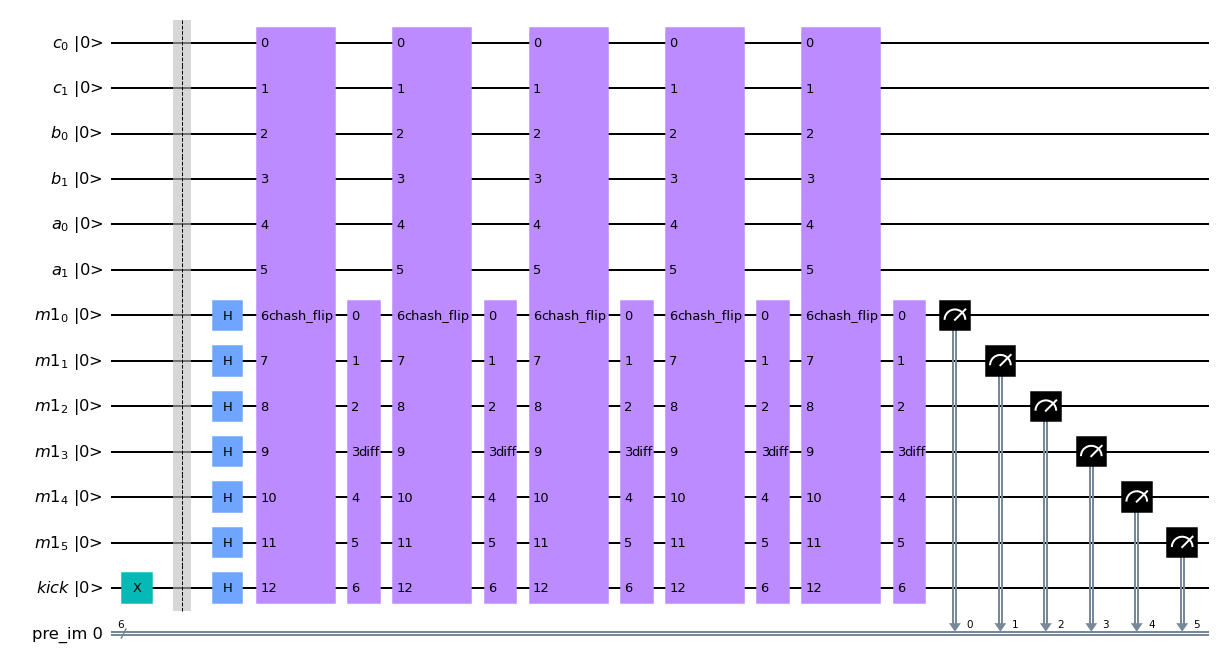

In [22]:
from math import sqrt, pi
res_qr = QuantumRegister(1, "res")

def construct_grover_circuit(flip_gate, diffusion_gate, N):
    """Construction of the Grover algorithm's circuit for a specific Flip and Diffusion gate. 
    Args:
        flip_gate (Quantum Gate): Phase Flip Operator for Grover's algorithm. 
        diffusion_gate (Quantum): Diffusion Flip Operator for Grover's algorithm.   
        N (int): Size of the domain of the function on which Grover's algorithm is applied.   
    Returns:
        grover_circuit (Quantum Circuit): Grover algorithm's circuit.
    """ 
    pre_im = ClassicalRegister(n, 'pre_im')
    a_qr = QuantumRegister(reg_len, 'a')
    b_qr = QuantumRegister(reg_len, 'b')
    c_qr = QuantumRegister(reg_len, 'c')
    m1_qr = QuantumRegister(n, 'm1')


    # Grover's algorithm works for both: F1 and the chash_round function 
    # Both have a different amount of qubits:
    # top case is chash round
    if flip_gate.label == 'chash_flip':
        grover_circuit = QuantumCircuit(c_qr, b_qr, a_qr, m1_qr, kickback_qr, pre_im)
        grover_round = QuantumCircuit(c_qr, b_qr, a_qr, m1_qr, kickback_qr)
    else: 
        grover_circuit = QuantumCircuit(c_qr, b_qr, a_qr, res_qr, m1_qr, kickback_qr, pre_im)
        grover_round = QuantumCircuit(c_qr, b_qr, a_qr, res_qr, m1_qr, kickback_qr)

    # init kickback
    grover_circuit.x(kickback_qr)
    grover_circuit.barrier()

    # init state
    grover_circuit.h([*range(n, 2*n+1)])

    # create Grover round
    if flip_gate.label == 'chash_flip':
        grover_round.append(flip_gate, [*range(2*n+1)])
        grover_round.append(diffusion_gate, [*range(n, 2*n+1)])
    else:
        grover_round.append(flip_gate, [*range(2*n+2)])
        grover_round.append(diffusion_gate, [*range(n+1, 2*n+2)])

    # repeat
    # https://docs.microsoft.com/en-us/azure/quantum/concepts-grovers
    repeats = int(pi/4 * sqrt(N) - 1/2)
        
    for i in range(repeats):
        grover_circuit.compose(grover_round, inplace=True)

    # measure outcome
    grover_circuit.measure(m1_qr, pre_im)

    return grover_circuit

# application and illustration
grover_circuit = construct_grover_circuit(flip_gate, diffusion_gate, 2**n)
grover_circuit.draw(output='mpl', initial_state=True)

### 2.6 Tesing of Grover's algorithm on Toy Hash (Round) Function

In [23]:
grover_circuit_up = construct_grover_circuit(flip_gate, diffusion_gate, 2**n)
result = execute(grover_circuit_up, simulator, shots=2**n).result()
counts = result.get_counts(grover_circuit_up)

# get t|he most frequent result
most_frequent = max(zip(counts.values(), counts.keys()))[1]

print("The result of Grover is {}.".format(most_frequent))  

The result of Grover is 111000.


For verification (we searched the preimage of H=0..00101 with IV=0..11111): 

In [24]:
# IV init
a = IV[:reg_len]
b = IV[reg_len:2*reg_len]
c = IV[2*reg_len:]

# m init
m = BitArray(bin=most_frequent)

a, b, c = chash_round(m,a,b,c)
hash = a + b + c

print("h({}, {}) = {}".format(m.bin, IV.bin, hash.bin))

h(111000, 011111) = 000101


Success! For further reference check out [[4]](https://cnot.io/quantum_algorithms/grover/grovers_algorithm.html).

## 3. Nostradamus Attack on Toy Hashfunction

### 3.1 The Simple Attack

Let's begin with the simplest attack presented in the paper [[1]](). An adversary publishes a hash value h before an event occurs. The goal of the adversary is to make it seem like he knew the outcome of the event before it occured. Thus, he publishes a "prophecy" P afterwards, such that the prophecy contains a description of the correct outcome and, when provided as input to the hash function, results in the previously published hash. He argues that the published hash is proof for his knowledge of the future. One simple way of achieving this goal is with Grover's algorithm.

In [25]:
def is_correct(m, y, H_list):
    a = y[:reg_len]
    b = y[reg_len:2*reg_len]
    c = y[2*reg_len:]
    a, b, c = chash_round(m, a, b, c)
    return a+b+c in H_list

In [26]:
def Grover(flip_gate, domain, y, H_list, measurement=''):
    """Implementation of Grover's algorithm for the chash_round function or F1. 
    Args: 
        flip_gate (Quantum Gate): Flip Gate of the specific function.  
        domain (int): the size of the domain divided by t. 
        measurment (str): specifies the type of measurement: collision (within diamond creation)
            or connection (within after_calculation).
    Returns:
        m (BitArray): classical bitstring of the preimage.
    """
    global ghost_grover_repititions, ghost_qfunction_calls_round, ghost_qfunction_calls_fcon, ghost_qfunction_calls_fcol

    # construct Grover's circuit 
    diffusion_gate, _ = construct_diffusion_gate()

    # init
    res = BitArray(uint=0, length = n)
    counter = 1
    repeats = int(pi/4 * sqrt(domain) - 1/2)
    
    # error
    if repeats==0:
        print("Grover's algorithm | Grover can not solve this task as the optimal repeats are 0.")
        raise Exception("Grover's algorithm | Grover can not solve this task as the optimal repeats are 0.")
        
    grover_circuit = construct_grover_circuit(flip_gate, diffusion_gate, domain)

    while counter<2 or (not is_correct(res, y, H_list)):

        print("Grover's algorithm | Starting Grover try {} with repeats={}.".format(counter, repeats))

        # simulate Grover's algorithm
        result = execute(grover_circuit, simulator, shots=2**n).result()
        counts = result.get_counts(grover_circuit)

        # get the most frequent result
        most_frequent = max(zip(counts.values(), counts.keys()))[1]
        res = BitArray(bin=most_frequent)
        print("Grover's algorithm | Finishing Grover try {}, found m={}.".format(counter, res.bin))

        if flip_gate.label == 'chash_flip':
            ghost_qfunction_calls_round += repeats
        elif measurement=='collision':
            ghost_qfunction_calls_fcol += repeats
        else:
            ghost_qfunction_calls_fcon += repeats
            
        if counter > 1:
            ghost_grover_repititions += 1

        counter = counter + 1

    return res

A complete attack with Grover's algorithm works as follows.

In [27]:
import time

def grover_attack(P, H):
    """Implementation of the preimage attack using Grover's algorithm.
    Args:
        P (BitArray): classical bitstring for the prophecy.
        H (BitArray): classical bitstring for the published hash.  
    Returns:
        P' (BitArray): classical bitstring for the prophecy, filled with zeros.
        m (BitArray): classical bitstring such that H(P||m) = H, where P was filled with 0 until B.
    """
    print("Step 0 | Starting Grover Attack for P =", P.bin, "and H =", H.bin)
    ghost_init()

    # time measurment 
    global ghost_after_time
    ghost_after_time = time.time()

    # Step 1 | fill P with zero's 
    while len(P) % n != 0:
        P = P + BitArray(bin='0')
    print("Step 1 | P filled with zeros:", P.bin)

    # Step 2 | classically calculate the last h-Evaluation of P
    p = chash(P, length_padding=False)
    print("Step 2 | Last h-Evaluation of P calculated p =", p.bin)

    # Step 3 | use Grover's algorithm to calculate a preimage m such that chash_round(m, p) = H
    print("Step 3 | Starting Grover's algorithm to find a preimage m such that chash_round(m, p) = H")
    flip_gate, _ = construct_flip_gate(H, p)
    m = Grover(flip_gate, 2**n, p, [H])
    print("Step 3 | Grover returns m =", m.bin)

    # time measurment 
    ghost_after_time = time.time() - ghost_after_time

    return P, m

Let's test this simple attack for a specific prophecy. Note that the parameter H can be freely chosen by the adversary. However, H is not the value which is returned by the hash function when length padding is enabled. In this case, we can precaulcute the real hash H' from H with a simple function that precalculates the length padding.

In [28]:
# construct parameters 
P = BitArray(bin='100101110')
H = BitArray(bin=n*'1')

In [29]:
from math import ceil

def precalculate_hash(P, H, num_blocks):
    """Precalculate hash for P if num_blocks are appended and length padding is used. 
    Args:
        P (BitArray): The unextended prophecy.   
        H (BitArray): The hash goal.
        num_blocks (int): The number of blocks which will be concatenated to P.   
    Returns:
        real_H (BitArray): The resulting hash value.
    """ 
    # precalc P_len
    P_len = ceil(len(P) / n) * n

    # precalc final prophecy_len
    fP_len = P_len + num_blocks * n

    # combine
    pad_len = fP_len % 5

    # calculate b
    rest = (1 + 4) % n
    b = -rest % n

    # precalc padding 
    padding = BitArray(bin='1' + b * '0' + (4-pad_len) * '0' + pad_len * '1')

    # precalculate hash
    a,b,c = chash_round(padding, H[:reg_len], H[reg_len:2*reg_len], H[2*reg_len:])
    real_H = a+b+c

    return real_H

# precalculate real hash H'
if len_pad:
    real_H = precalculate_hash(P, H, 1) 

    print("The real hash value will be H' =", real_H.bin)

The real hash value will be H' = 001110


In [30]:
# attack
P, m = grover_attack(P, H)

Step 0 | Starting Grover Attack for P = 100101110 and H = 111111
Step 1 | P filled with zeros: 100101110000
Step 2 | Last h-Evaluation of P calculated p = 010010
Step 3 | Starting Grover's algorithm to find a preimage m such that chash_round(m, p) = H
Grover's algorithm | Starting Grover try 1 with repeats=5.
Grover's algorithm | Finishing Grover try 1, found m=100100.
Step 3 | Grover returns m = 100100


In the process we used the following ressources.

In [31]:
print_ghost_variables()

In the previous attack:
A hash function with size n=6 and B=6 was attacked.
The pre calculation took 0 seconds.
The after calculation took 11.493750095367432 seconds.
Therefore the total took 11.493750095367432 seconds.
4 classical round function calls were required.
5 quantum round function calls were required.
0 quantum function calls to F_collision were required.
0 quantum function calls to F_connection were required.
0 Grover repitions were required.
0 Values were sampled.


Let's check if the results are correct! Remember that we searched for an m such that H(P||m)=H=111111.

In [32]:
# construct input
bin_in = P + m
print("H({}) = {}".format(bin_in.bin, chash(bin_in, length_padding=len_pad).bin))

if len_pad:
    print("We previously declared the real hash value will be H' =", real_H.bin)
    print("h*({}) = {}".format(bin_in.bin, chash(bin_in, length_padding=False).bin))

H(100101110000100100) = 001110
We previously declared the real hash value will be H' = 001110
h*(100101110000100100) = 111111


Awesome!

### 3.2 The Quantum Nostradamus Attack

The simple attack from the previous section can be further improved by the second presented attack in the paper [[1]](). Indeed, we first construct a diamond in a precalculation to increase the probability of finding a collision with Grover. We need to construct four core algorithms for this attack:
1. quantum find collision algorithm: to efficiently find collisions of the hash round function, which are required for the diamond construction. 
2. quantum diamond construction: to construct a diamond of hash values such that finding gibberish m such that H(P||m) = h for a published hash value h becomes more efficient. 
3. quantum find connection algorithm: the actual algorithm to find the gibberish m (parts of it) and connect P with the diamond. 
4. the quantum attack itself: all the above algorithms combined in a single attack.

#### 3.2.1 Quantum Find Collision Algorithm

For this first algorithm, we need to construct a function F1 where for 2^l fixed messages m_i, y and y* it holds that

$$ F\left( m \right) = 1\Leftrightarrow \exists i\in \left\{ 1,\ldots,2^{l} \right\}:h\left( m_{i},y \right) = h\left( m,y^{*} \right) $$

Let's construct a quantum circuit for F1. 

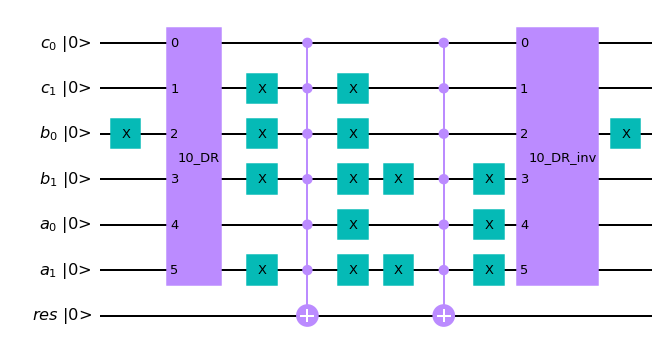

In [33]:
def construct_f1_gate(hash_list, y2):
    """Construction of the Gate for the F1 function. 
    Args:
        hash_list (List of BitArrays): List of 2^l messages m_i.    
        y2 (BitArray): Value y* in the definition of F1.   
    Returns:
        f1_gate (Quantum Gate): The Gate for the F1 function.
        img (Image): Image of the quantum circuit.
    """ 
    a_qr = QuantumRegister(reg_len, 'a')
    b_qr = QuantumRegister(reg_len, 'b')
    c_qr = QuantumRegister(reg_len, 'c')

    F1_circuit = QuantumCircuit(c_qr, b_qr, a_qr, res_qr)

    # init a,b,c according to y2
    IV = BitArray(y2)
    IV.reverse()
    for i, bit in enumerate(IV):
        if bit == 1:
            F1_circuit.x(i)

    # apply chash_round
    F1_circuit.append(round_gate,[*range(n)])
    
    # comparison for every hash in list
    for hash in hash_list:
        hash_tmp = BitArray(hash)
        hash_tmp.reverse()
        for i, bit in enumerate(hash_tmp):
            if bit == 0:
                F1_circuit.x(i)

        F1_circuit.mct([*range(n)], res_qr)

        for i, bit in enumerate(hash_tmp):
            if bit == 0:
                F1_circuit.x(i)
    
    # invert chash_round
    DR_inv = round_gate.inverse()
    DR_inv.label = "10_DR_inv"
    F1_circuit.append(DR_inv,[*range(n)])

    # invert: init a,b,c according to y2
    IV = BitArray(y2)
    IV.reverse()
    for i, bit in enumerate(IV):
        if bit == 1:
            F1_circuit.x(i)

    # convert to quantum gate
    F1_gate = F1_circuit.to_gate(label='F1')

    # draw circuit
    img = F1_circuit.draw(output='mpl', initial_state=True)

    return F1_gate, img

# application and illustration
m1 = BitArray(bin=(n-6) *'0') + BitArray(bin='001100')
m2 = BitArray(bin=(n-6) *'0') + BitArray(bin='110101')
y1 = BitArray(bin=(n-6) *'0') + BitArray(bin='111100')
y2 = BitArray(bin=(n-6) *'0') + BitArray(bin='000100')

a,b,c = chash_round(m1, y1[:reg_len], y1[reg_len:2*reg_len], y1[2*reg_len:])
hash1 = a + b + c
a,b,c = chash_round(m2, y1[:reg_len], y1[reg_len:2*reg_len], y1[2*reg_len:])
hash2 = a + b + c

f1_gate, img = construct_f1_gate([hash1, hash2], y2)
img 

Let's test the circuit on two examples. First, for an arbitrary message, the circuit is supposed to return 0.

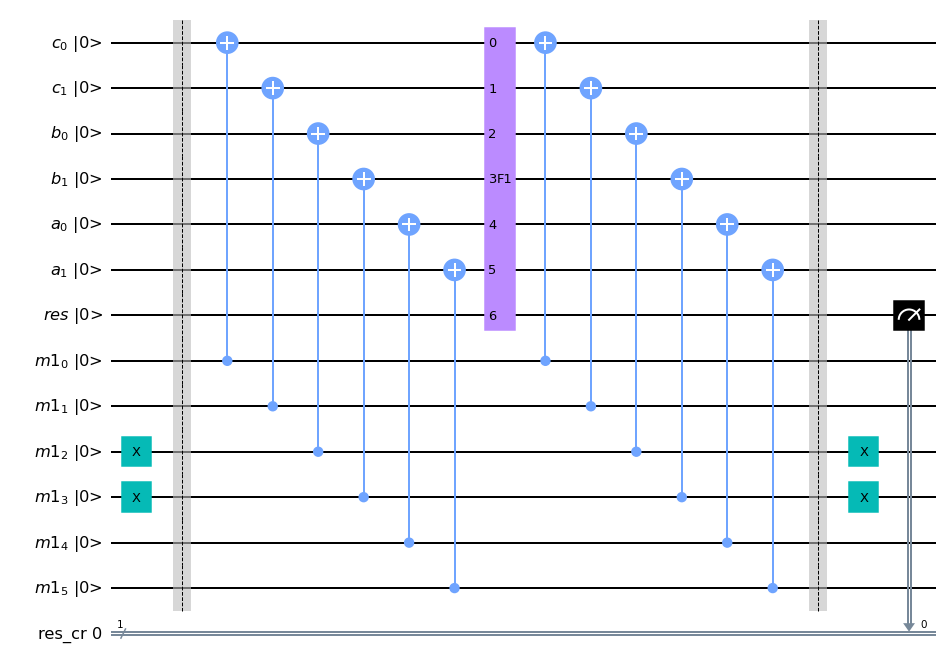

In [34]:
res_cr = ClassicalRegister(1, "res_cr")
# construct a circuit for test purposes
test_circuit_f1_m1 = QuantumCircuit(c_qr, b_qr, a_qr, res_qr, m1_qr, res_cr)

# init m1 
# note that chash_round(110010, y1) != chash_round(110010, y2)
IV = BitArray(m1)
IV.reverse()
for i, bit in enumerate(IV):
    if bit == 1:
        test_circuit_f1_m1.x(i+n+1)

test_circuit_f1_m1.barrier()    

# sponge construction
test_circuit_f1_m1.cnot(m1_qr, [*range(n)])

# apply gate
test_circuit_f1_m1.append(f1_gate, [*range(n+1)])

# invert: sponge construction
test_circuit_f1_m1.cnot(m1_qr, [*range(n)])

test_circuit_f1_m1.barrier()

# invert: init m1
IV = BitArray(m1)
IV.reverse()
for i, bit in enumerate(IV):
    if bit == 1:
        test_circuit_f1_m1.x(i+n+1)

# measure outcome
test_circuit_f1_m1.measure(n, res_cr)

# draw circuit
test_circuit_f1_m1.draw(output='mpl', initial_state=True)

In [35]:
result = execute(test_circuit_f1_m1, simulator, shots=2**n).result()
counts = result.get_counts(test_circuit_f1_m1)

# get the most frequent result
most_frequent = max(zip(counts.values(), counts.keys()))[1]
print("The result is F1({}) = {}.".format(m1.bin, most_frequent))

The result is F1(001100) = 0.


Secondly, for a message with the same hash value, the function is supposed to return 1. Let's quickly find such a message with the help of Grover's algorithm and then continue with the testing.

In [36]:
flip_gate, _ = construct_flip_gate(hash1, y2)
m = Grover(flip_gate, 2**n, y2, [hash1])
print("The result of Grover is {}.".format(m.bin))

Grover's algorithm | Starting Grover try 1 with repeats=5.
Grover's algorithm | Finishing Grover try 1, found m=110100.
The result of Grover is 110100.


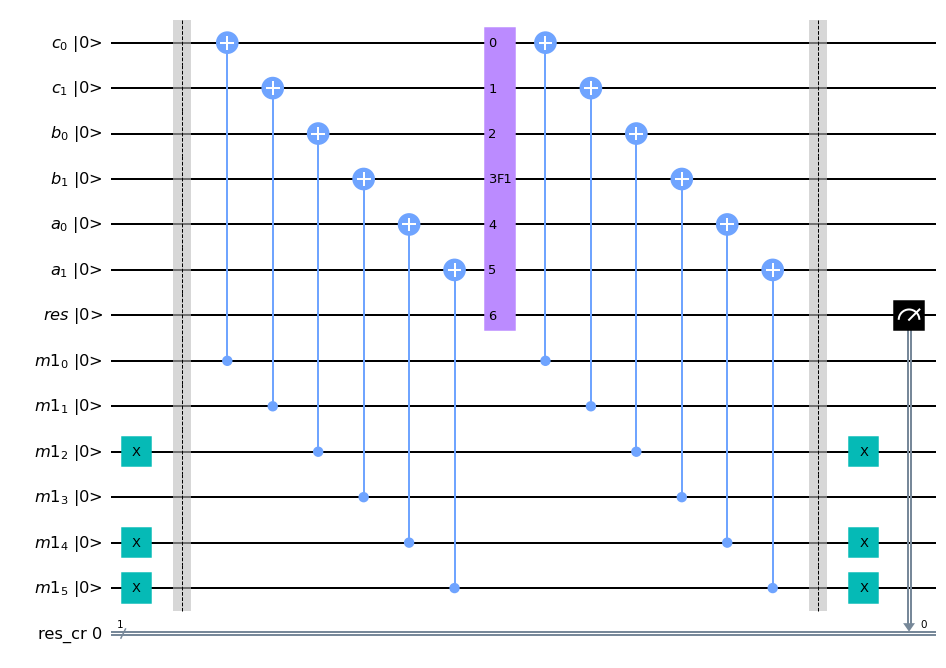

In [37]:
# construct a circuit for test purposes
test_circuit_f1_m3 = QuantumCircuit(c_qr, b_qr, a_qr, res_qr, m1_qr, res_cr)

# init m
IV = BitArray(m)
IV.reverse()
for i, bit in enumerate(IV):
    if bit == 1:
        test_circuit_f1_m3.x(i+n+1)

test_circuit_f1_m3.barrier() 

# sponge construction
test_circuit_f1_m3.cnot(m1_qr, [*range(n)])

# apply gate
test_circuit_f1_m3.append(f1_gate, [*range(n+1)])

# invert: sponge construction
test_circuit_f1_m3.cnot(m1_qr, [*range(n)])

test_circuit_f1_m3.barrier()

# invert: init m
IV = BitArray(m)
IV.reverse()
for i, bit in enumerate(IV):
    if bit == 1:
        test_circuit_f1_m3.x(i+n+1)

# measure outcome
test_circuit_f1_m3.measure(n, res_cr)

# draw circuit
test_circuit_f1_m3.draw(output='mpl', initial_state=True)

In [38]:
result = execute(test_circuit_f1_m3, simulator, shots=2**n).result()
counts = result.get_counts(test_circuit_f1_m3)

# get the most frequent result
most_frequent = max(zip(counts.values(), counts.keys()))[1]
print("The result is F1({}) = {}.".format(m.bin, most_frequent))

The result is F1(110100) = 1.


Perfect. Let's continue with the construction of the phase flip gate for F1 to constitute the qfind_collision algorithm. 

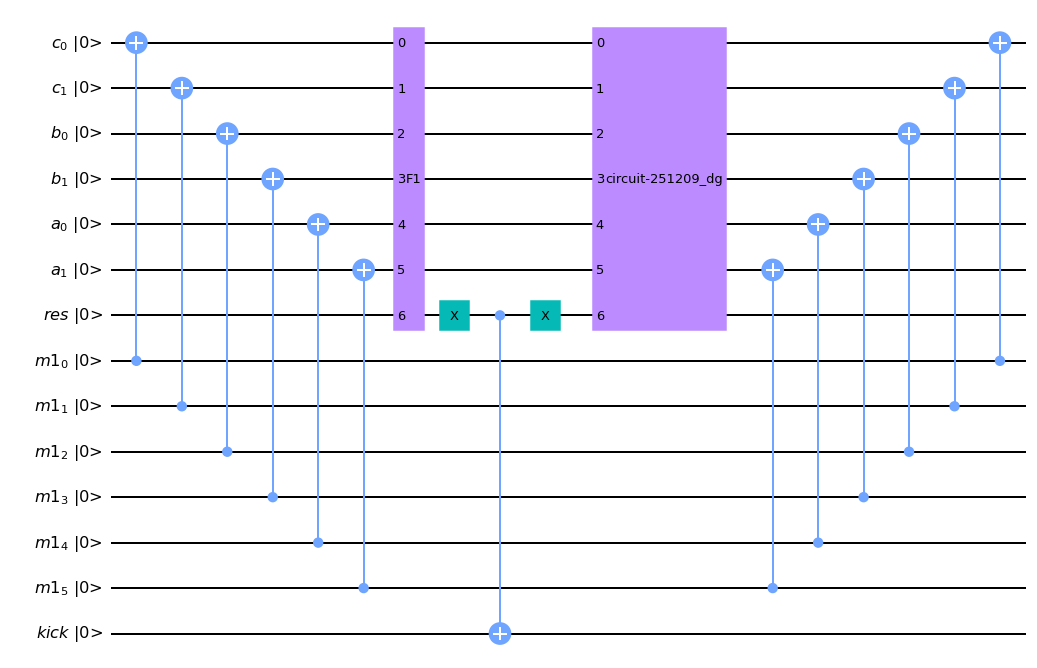

In [39]:
def construct_flip_gate_f1(b, hash_list, y2):
    """Construction of the Phase Flip Operator for the F1 function. 
    Args:
        b (BitArray): classical bitstring of the image of F1.  
        hash_list (List of BitArrays): List of 2^l messages m_i.    
        y2 (BitArray): Value y* in the definition of F1.  
    Returns:
        f1_flip_gate (Quantum Gate): Phase Flip Operator for F1.
        img (Image): Image of the quantum circuit.
    """ 
    a_qr = QuantumRegister(reg_len, 'a')
    b_qr = QuantumRegister(reg_len, 'b')
    c_qr = QuantumRegister(reg_len, 'c')
    m1_qr = QuantumRegister(n, 'm1')

    f1_gate, _ = construct_f1_gate(hash_list, y2)        
    
    f1_phase_flip = QuantumCircuit(c_qr, b_qr, a_qr, res_qr, m1_qr, kickback_qr)
    f1_phase_flip_side = QuantumCircuit(c_qr, b_qr, a_qr, res_qr, m1_qr, kickback_qr)

    # sponge construction
    f1_phase_flip_side.cnot(m1_qr, [*range(n)])

    # apply f1
    f1_phase_flip_side.append(f1_gate,[*range(n+1)])

    # calculate specific controlled gate for preimage H
    if b == 1:
        f1_phase_flip_side.x(n)
    
    # apply all above operations to quantum circuit
    f1_phase_flip.compose(f1_phase_flip_side, inplace=True)

    # phase flip multi-cnot
    f1_phase_flip.cnot(n, kickback_qr)

    # apply the inverse of all above operations to quantum circuit
    f1_phase_flip.compose(f1_phase_flip_side.inverse(), inplace=True)

    # convert to quantum gate
    f1_flip_gate = f1_phase_flip.to_gate(label='f1_flip')

    # draw circuit
    img = f1_phase_flip.draw(output='mpl', initial_state=True)

    return f1_flip_gate, img

# application and illustration
m1 = BitArray(bin=(n-6) *'0') + BitArray(bin='110010')
m2 = BitArray(bin=(n-6) *'0') + BitArray(bin='110101')
y1 = BitArray(bin=(n-6) *'0') + BitArray(bin='111100')
y2 = BitArray(bin=(n-6) *'0') + BitArray(bin='000100')

a,b,c = chash_round(m1, y1[:reg_len], y1[reg_len:2*reg_len], y1[2*reg_len:])
hash1 = a + b + c
a,b,c = chash_round(m2, y1[:reg_len], y1[reg_len:2*reg_len], y1[2*reg_len:])
hash2 = a + b + c

f1_flip_gate, img = construct_flip_gate_f1(1, [hash1, hash2], y2)
img

Let's combine everything in the qfind_collision algorithm.

In [40]:
import random
from math import ceil

def qfind_collision(y1, y2):
    """Given two hash values y1, y2, the algorithm finds a pair of messages m1, m2 
        such that h(m1, y1) = h(m2, y2).
    Args:
        y1 (BitArray): classical bitstring for the first hash value.
        y2 (BitArray): classical bitstring for the second hash value.
    Returns:
        m1 (BitArray): classical bitstring for the first message.
        m2 (BitArray): classical bitstring for the second message.
        h (BitArray): classical bitstring for the common hash.
    """
    global ghost_sampling

    # empty set of samples as dictionary
    samples = {}
    hash_list = []

    # Randomly sample messages mi for i=1..2^l and calculate h(mi, y1).
    # If h(mi, y1) == h(mj, y1) for i!=j sample new mi.
    
    l = ceil((n-2)/3)

    while len(hash_list) < 2**l:
        random_bits = random.getrandbits(n)
        mi = BitArray(uint = random_bits, length = n)
        ghost_sampling += 1
    
        h1, h2, h3 = chash_round(mi, y1[:reg_len], y1[reg_len:2*reg_len], y1[2*reg_len:])
        hash_mi = h1 + h2 + h3

        # skip if already in list
        if samples.get(hash_mi.bin) == None:
            samples[hash_mi.bin] = mi
            hash_list.append(hash_mi)

    print("qfind_collision | Hash-Samples: {}".format(list(samples.keys())))

    # apply Grover for preimage 1 on Function F with F(m) = 1 :⇔ ∃i ∈ {1,...,2l} : h(mi,y1) = h(m,y2)
    # the result is mgrov
    f1_flip_gate, _ = construct_flip_gate_f1(1, hash_list, y2)
    mgrov = Grover(f1_flip_gate, 2**(n-l), y2, hash_list, measurement='collision')

    # find i in samples such that h(mi,y) = h(m∗,y2)
    h1, h2, h3 = chash_round(mgrov, y2[:reg_len], y2[reg_len:2*reg_len], y2[2*reg_len:])
    hash_grov = h1 + h2 + h3

    print("qfind_collision | H({})={}".format(mgrov.bin, hash_grov.bin))
    mres = None

    for hash in samples:

        # found mi
        if hash == hash_grov.bin:
            mres = samples[hash]
            break

    # error 
    if mres == None:
        print("qfind_collision | Grover found {}. However the corresponding hash does not corresponds to any hash in the samples.".format(mgrov.bin))
        raise Exception("Grover found {}. However the corresponding hash does not corresponds to any hash in the samples.".format(mgrov.bin))

    return mres, mgrov, hash_grov

Let's check if the results of this method are correct. Recall that h(m1,y1) == h(m2,y2).

In [41]:
# construct parameters 
y1 = BitArray(bin=(n-6) *'0') + BitArray(bin='100101')
y2 = BitArray(bin=(n-6) *'0') + BitArray(bin='111011')

# test method
m1, m2, _ = qfind_collision(y1, y2)
a,b,c = chash_round(m1, y1[:reg_len], y1[reg_len:2*reg_len], y1[2*reg_len:])
res_m1 = a + b + c
a,b,c = chash_round(m2, y2[:reg_len], y2[reg_len:2*reg_len], y2[2*reg_len:])
res_m2 = a + b + c
print("h({},{}) = {} and h({},{}) = {}.".format(m1.bin, y1.bin, res_m1.bin, m2.bin, y2.bin, res_m2.bin))

qfind_collision | Hash-Samples: ['100001', '011101', '001001', '001110']
Grover's algorithm | Starting Grover try 1 with repeats=2.
Grover's algorithm | Finishing Grover try 1, found m=001100.
qfind_collision | H(001100)=100001
h(010010,100101) = 100001 and h(001100,111011) = 100001.


#### 3.2.2 Quantum Diamond Construction

We've just implemented the qfind_collusion quantum algorithm and can now continue with the diamond construction. The basic idea is that we build a balanced binary tree such that instead of finding one specific hash value, we can find each of the 2^(k-1) leafs. Subsequently, each of the leafs will lead to the same hash value because of the iterative nature of the hash algorithm. This increases the probability of finding a collision. 

In [42]:
def qconstruct_diamond(k = -1):
    """Given a height k, the algorithm constructs a diamond of hash values based on 
        qfind_collision.
    Returns:
        nodes (List of Lists of BitArrays): Nodes in the diamond.
        edges (List of List of BitArrays): Edges in the diamond. 
    """
    global ghost_sampling

    # init parameters 
    nodes = []
    edges = []
    samples = {}

    # sample 2^k random distinct bitstrings 
    if k==-1:
        k = ceil(n/9 - 2/3)
        # k = ceil(n/7)

    print("qconstruct_diamond | Sampling 2^{} bitstrings.".format(k))
    while len(samples) < 2**k:
        random_bits = random.getrandbits(n)
        yi = BitArray(uint = random_bits, length = n)
        ghost_sampling += 1

        # skip if already in list
        if samples.get(yi.bin) == None:
            samples[yi.bin] = yi
    
    # repeat until s=1
    for s in reversed(range(1, k+1)):

        print("qconstruct_diamond | Starting loop {}/{}.".format(k-s, k-1))
        # init loop parameters
        if (s==k):
            samples_list = list(samples.values())
            # construct diamond nodes
            nodes.append(samples_list)
        else:
            samples_list = new_samples
        new_samples = []
        new_edges = []

        for i in range(2**(s-1)):
            # calculate edges 
            y1 = samples_list[2*i]
            y2 = samples_list[2*i+1]
            
            print("qconstruct_diamond | Finding collision between {} and {} with qfind_collision.".format(y1.bin, y2.bin))
            m1, m2, y_new = qfind_collision(y1, y2)

            new_edges.append(m1)
            new_edges.append(m2)
        
            # calulcate new nodes
            new_samples.append(y_new)
        
        # construct diamond edges
        edges.append(new_edges)

        # construct diamond nodes
        nodes.append(new_samples)

    return nodes, edges

# application 
nodes, edges = qconstruct_diamond(k=2)

qconstruct_diamond | Sampling 2^2 bitstrings.
qconstruct_diamond | Starting loop 0/1.
qconstruct_diamond | Finding collision between 101111 and 001000 with qfind_collision.
qfind_collision | Hash-Samples: ['100111', '110010', '101010', '000110']
Grover's algorithm | Starting Grover try 1 with repeats=2.
Grover's algorithm | Finishing Grover try 1, found m=001011.
qfind_collision | H(001011)=101010
qconstruct_diamond | Finding collision between 100010 and 011011 with qfind_collision.
qfind_collision | Hash-Samples: ['110100', '001101', '010001', '100111']
Grover's algorithm | Starting Grover try 1 with repeats=2.
Grover's algorithm | Finishing Grover try 1, found m=101011.
qfind_collision | H(101011)=010001
qconstruct_diamond | Starting loop 1/1.
qconstruct_diamond | Finding collision between 101010 and 010001 with qfind_collision.
qfind_collision | Hash-Samples: ['100001', '110010', '000011', '011111']
Grover's algorithm | Starting Grover try 1 with repeats=2.
Grover's algorithm | Fini

In [43]:
def print_diamond(nodes, edges):
    """Given the nodes and edges of a diamond this algorithm vizualizes the construction.
    Args:
        nodes (List of Lists of BitArrays): Nodes in the diamond.
        edges (List of List of BitArrays): Edges in the diamond. 
    """
    for i, node_list in enumerate(nodes):
        # print nodes
        print()
        print((2**i-1)*int(n)*" ", end="")
        for node in node_list:
            print(node.bin, end=(2**(i+1)-1)*int(n)*" ")

        # print edges 
        if i < len(edges):
            print()
            print((2**i-1)*int(n)*" ", end="")
            for edge in edges[i]:
                print(edge.bin, end=(2**(i+1)-1)*int(n)*" ")

print_diamond(nodes, edges)


101111      001000      100010      011011      
101100      001011      010010      101011      
      101010                  010001                  
      101100                  010111                  
                  000011                                          

#### 3.2.3 Quantum Find Connection Algorithm 

To use the diamond, we need to find a connection message mcon such that H(P||mcon) maps to a leaf in the diamond. Constructing a final prophecy P' is as easy as appending all the edges in the diamond to P||mcon. As a result, the final prophecy maps to the previously published root of the diamond. 

In [44]:
from math import log2

def qfind_connection(P, nodes):
    """Given a diamond, the algorithm finds a connection message mcon, such that h(mcon,p)=yi
    where yi is a leaf of the diamond and p is H(P||00..00)=p.
    Args:
        P (BitArray): classical bitstring for the prophecy.
        nodes (List of Lists of BitArrays): Nodes in the diamond.
    Returns:
        mcon (BitArray): classical bitstring of the message mcon.
        leaf_index (int): index of the leaf in leafs (nodes[0]).
        P' (BitArray): classical bitstring for the prophecy, filled with zeros.
    """
    # Step 1 | fill P with zero's 
    while len(P) % n != 0:
        P = P + BitArray(bin='0')
    print("qfind_connection | P filled with zeros:", P.bin)

    # Step 2 | classically calculate the last h-Evaluation of P
    p = chash(P, length_padding=False)
    print("qfind_connection | Last h-Evaluation of P calculated p =", p.bin)

    # Step 3 | use F1 and Grover's algorithm to calculate a preimage m such that chash_round(mcon, p) = yi
    print("qfind_connection | Starting Grover's algorithm to find a preimage mcon such that chash_round(mcon, p) = yi.")
    leafs = nodes[0]

    # apply Grover for preimage 1 on Function F with F(m) = 1 :⇔ ∃i: h(mcon,p) = yi
    # the result is mcon
    f1_flip_gate, _ = construct_flip_gate_f1(1, leafs, p)
    leaf_count = len(leafs)
    k = ceil(log2(leaf_count))
    mcon = Grover(f1_flip_gate, 2**(n-k), p, leafs, measurement='connection')

    # find i in samples such that h(mcon,p) = yi
    h1, h2, h3 = chash_round(mcon, p[:reg_len], p[reg_len:2*reg_len], p[2*reg_len:])
    hash_con = h1 + h2 + h3

    for i, leaf in enumerate(leafs):

        # found mi
        if leaf == hash_con:
            leaf_index = i
            break
    
    return mcon, leaf_index, P

# application
P = BitArray(bin='100101110')
mcon, leaf_index, P = qfind_connection(P, nodes)

qfind_connection | P filled with zeros: 100101110000
qfind_connection | Last h-Evaluation of P calculated p = 010010
qfind_connection | Starting Grover's algorithm to find a preimage mcon such that chash_round(mcon, p) = yi.
Grover's algorithm | Starting Grover try 1 with repeats=2.
Grover's algorithm | Finishing Grover try 1, found m=110110.


In [45]:
# construct parameters
m = P + mcon 
check_leaf = nodes[0][leaf_index]
H = chash(m, length_padding=False)

print("h*({}) = {} and leaf = {}.".format(m.bin, H.bin, check_leaf.bin))

h*(100101110000110110) = 101111 and leaf = 101111.


#### 3.2.4 The Nostradamus Quantum Attack

Let's continue by testing our attack in a specific scenario: the win/loose sequence of football games for one specific team. We first precalculate a hash H before the season starts. After all of the football games, we need to find a bitstring P that encodes the win/loose sequence, such that H(P)=H. We begin by precomputing a diamond structure. Note that the prophecy can be arbitrarily large: the only constraint is the correct encoding of the win/loose sequence in the first bits. However, we need to guess the amount of blocks the final prophecy might have to approximate the correct length padding beforehand. Therefore, we guess the length by assigning an arbitrary bitstring to prophecy p with approximately the same length.

In [46]:
P = BitArray(bin='0000000000')

In [47]:
def qnostradamus_attack_precalc(k = -1):
    """Implementation of the quantum Nostradamus attack precalculation. 
    Args:
        k (int): size of the diamond
    Returns:
        nodes (List of Lists of BitArrays): Nodes in the diamond.
        edges (List of List of BitArrays): Edges in the diamond. 
        root (BitArray): root of diamond or hash of root of diamond and precalculated length padding.
    """
    # init eval parameters
    ghost_init()

    if k==-1:
        k = ceil(n/9 - 2/3)
        # k = ceil(n/7)

    # time measurment 
    global ghost_pre_time
    ghost_pre_time = time.time()

    print("Step 1 | Construct diamond of hash values.")
    nodes, edges = qconstruct_diamond(k)
    
    root = nodes[-1][0]
    if len_pad:
        root = precalculate_hash(P, root, k+1)
        print("Step 2 | Return hash of root of diamond and precalculated length padding: {}.".format(root.bin))
    else:
         print("Step 2 | Return root of diamond: {}.".format(root.bin))
        

    # time measurment
    ghost_pre_time = time.time() - ghost_pre_time

    return nodes, edges, root

# application
nodes, edges, root = qnostradamus_attack_precalc(3)

Step 1 | Construct diamond of hash values.
qconstruct_diamond | Sampling 2^3 bitstrings.
qconstruct_diamond | Starting loop 0/2.
qconstruct_diamond | Finding collision between 110100 and 100100 with qfind_collision.
qfind_collision | Hash-Samples: ['011111', '100110', '110000', '101001']
Grover's algorithm | Starting Grover try 1 with repeats=2.
Grover's algorithm | Finishing Grover try 1, found m=111001.
qfind_collision | H(111001)=101001
qconstruct_diamond | Finding collision between 001011 and 101111 with qfind_collision.
qfind_collision | Hash-Samples: ['011001', '111100', '110100', '110101']
Grover's algorithm | Starting Grover try 1 with repeats=2.
Grover's algorithm | Finishing Grover try 1, found m=011100.
qfind_collision | H(011100)=111100
qconstruct_diamond | Finding collision between 110010 and 100001 with qfind_collision.
qfind_collision | Hash-Samples: ['011110', '000100', '011100', '101101']
Grover's algorithm | Starting Grover try 1 with repeats=2.
Grover's algorithm | F

We now publish the paramter root as hash H.

Our constructed diamond looks as follows.

In [48]:
print_diamond(nodes, edges)


110100      100100      001011      101111      110010      100001      100011      010101      
101001      111001      111000      011100      101001      111010      010001      100111      
      101001                  111100                  011110                  010100                  
      101111                  111010                  100000                  101010                  
                  000011                                          001011                                          
                  001001                                          000001                                          
                                          110010                                                                                          

A few months go by, and the season ends. For example, the team could have won the first three games, lost two, and won five more.

In [49]:
P = BitArray(bin='1110011111')

We continue by constructing a prophcy P' out of the correct sequence P with the diamond.

In [50]:
def qnostradamus_attack_aftercalc(P, nodes, edges):
    """Implementation of the quantum Nostradamus attack after the event occurred. 
    Args:
        P (BitArray): classical bitstring for the prophecy.
        nodes (List of Lists of BitArrays): Nodes in the diamond.
        edges (List of Lists of BitArrays): Edges in the diamond.
    Returns:
        P' (BitArray): classical bitstring of the final prophecy that is published.
    """

    # time measurment
    global ghost_after_time
    ghost_after_time = time.time()

    print("Step 3 | Find connection message.")
    mcon, leaf_index, P = qfind_connection(P, nodes)
    print("Step 3 | Found mcon={}.".format(mcon.bin))

    print("Step 4 | Constructing the final prophecy.")
    P = P + mcon 

    # find path in diamond 
    i = leaf_index
    for j, edge_list in enumerate(edges):
        current_edge = edge_list[i]
        print("Step 4 | Current edge through diamond={} (Layer {}, Index {}).".format(current_edge.bin, j, i))
        P = P + current_edge
        i = int(i/2)

    # time measurment
    ghost_after_time = time.time() - ghost_after_time

    return P

# application
P_new = qnostradamus_attack_aftercalc(P, nodes, edges)

Step 3 | Find connection message.
qfind_connection | P filled with zeros: 111001111100
qfind_connection | Last h-Evaluation of P calculated p = 001011
qfind_connection | Starting Grover's algorithm to find a preimage mcon such that chash_round(mcon, p) = yi.
Grover's algorithm | Starting Grover try 1 with repeats=1.
Grover's algorithm | Finishing Grover try 1, found m=111100.
Step 3 | Found mcon=111100.
Step 4 | Constructing the final prophecy.
Step 4 | Current edge through diamond=111010 (Layer 0, Index 5).
Step 4 | Current edge through diamond=100000 (Layer 1, Index 2).
Step 4 | Current edge through diamond=000001 (Layer 2, Index 1).


We used the following resources in the process.

In [51]:
print_ghost_variables()

In the previous attack:
A hash function with size n=6 and B=6 was attacked.
The pre calculation took 80.12222909927368 seconds.
The after calculation took 8.321399927139282 seconds.
Therefore the total took 88.44362902641296 seconds.
48 classical round function calls were required.
0 quantum round function calls were required.
14 quantum function calls to F_collision were required.
1 quantum function calls to F_connection were required.
0 Grover repitions were required.
37 Values were sampled.


We now submit this bitstring P_new as prophecy because it holds that H(P_new)=H.

In [52]:
H = chash(P_new, length_padding=len_pad)
print("H({}) = {} where the submitted hash value was root = {}.".format(P_new.bin, H.bin, root.bin))

H(111001111100111100111010100000000001) = 100010 where the submitted hash value was root = 100010.


### 3.3 An improved Version of the Quantum Nostradamus Attack

Before we finish this notebook with the evaluation, we introduce an improvement of the quantum Nostradamus Attack that was first proposed by Barbara Jiabao Benedikt. In simple words the improvement changes the process of sampling during the diamond creation by creating samples for (half of) the values in one layer of the diamond instead of only a pair of values at once. This reduces the total amount of samples that are necessary for the diamond creation, while the run time of Grover's algorithm remains the same. 

In [53]:
def improved_qconstruct_diamond(k = -1):
    """Given a height k, this improved version of the algorithm constructs a diamond of hash values based on 
        qfind_collision.
    Returns:
        nodes (List of Lists of BitArrays): Nodes in the diamond.
        edges (List of List of BitArrays): Edges in the diamond. 
    """
    global ghost_sampling

    # init diamond parameters 
    edges = []

    # init current and new diamond values
    diamond_samples = {} # dictionary so that all values are different

    # sample 2^k random distinct bitstrings 
    if k==-1:
        k = ceil(n/7)

    print("qconstruct_diamond | Sampling 2^{} bitstrings.".format(k))
    while len(diamond_samples) < 2**k:
        random_bits = random.getrandbits(n)
        yi = BitArray(uint = random_bits, length = n)
        ghost_sampling += 1

        # skip if already in list
        if diamond_samples.get(yi.bin) == None:
            diamond_samples[yi.bin] = yi
    
    # repeat until s=1
    for s in reversed(range(1, k+1)):

        print("qconstruct_diamond | Starting loop {}/{}.".format(k-s, k-1))
        # init loop parameters
        if (s==k):
            diamond_samples_list = list(diamond_samples.values())
        else:
            diamond_samples_list = new_diamond_samples

        # init sample values and corresponding hashs 
        new_diamond_samples = []
        hash_dic = {}
        hash_list = []
        samples = {}
        new_edges = []
        j = 0

        # for every value in the upper half of the diamond layer 
        for diamond_value in diamond_samples_list[2**(s-1):]:

            # Randomly sample messages mi for i=1..2^l and calculate h(mi, yj) for different j's.
            # If the hash was already sampled, sample again.
            
            l = ceil((n+2*s-2*log2(s))/3)
            # l = ceil((n-2)/3)
            
            print("qconstruct_diamond | Creating up to 2^{} new hash values for the diamond values in the current layer.".format(l))
            while len(samples) < 2**l:
                random_bits = random.getrandbits(n)
                m = BitArray(uint = random_bits, length = n)
                ghost_sampling += 1

                # circular selection increment until unprocessed Node (first half of values)
                while hash_dic.get(j) == -1:
                    j = (j + 1) % 2**(s-1)
                y = diamond_samples_list[j]
        
                h1, h2, h3 = chash_round(m, y[:reg_len], y[reg_len:2*reg_len], y[2*reg_len:])
                hash_m = h1 + h2 + h3

                # skip if already in list
                if samples.get(hash_m.bin) == None:
                    samples[hash_m.bin] = (j, m)
                    hash_list.append(hash_m)

                    # remember index
                    if hash_dic.get(j) == None:
                        hash_dic[j] = [hash_m]
                    else:
                        hash_dic[j].append(hash_m)

                    # increment 
                    j = (j + 1) % 2**(s-1)
        

            print("qfind_collision | Hash-Samples: {}".format(hash_dic))

            # apply Grover for preimage 1 on Function F with F(m') = 1 :⇔ ∃i ∈ {1,...,2l} : h(m,y) = h(m',diamond_value)
            # the result is mgrov
            f1_flip_gate, _ = construct_flip_gate_f1(1, hash_list, diamond_value)
            mgrov = Grover(f1_flip_gate, 2**(n-l), diamond_value, hash_list, measurement='collision')

            # find i in samples such that h(mi,y) = h(m∗,y2)
            h1, h2, h3 = chash_round(mgrov, diamond_value[:reg_len], diamond_value[reg_len:2*reg_len], diamond_value[2*reg_len:])
            hash_grov = h1 + h2 + h3

            print("qfind_collision | H({})={}".format(mgrov.bin, hash_grov.bin))
            
            # add to new layer
            new_diamond_samples.append(hash_grov)

            # find other message with same hash
            mres = None

            for hash in samples:

                # found m
                if hash == hash_grov.bin:
                    (jres, mres) = samples[hash]
                    break

            # potential error 
            if mres == None:
                print("qfind_collision | Grover found {}. However the corresponding hash does not corresponds to any hash in the samples".format(mgrov.bin))
                raise Exception("Grover found {}. However the corresponding hash does not corresponds to any hash in the samples".format(mgrov.bin))

            # connect nodes 
            new_edges.append((diamond_value, mgrov, hash_grov))
            y = diamond_samples_list[jres]
            new_edges.append((y, mres, hash_grov))

            print("qfind_collision | The collision corresponds to the node {} at index {} with message {}.".format(y.bin, jres, mres.bin))

            # steps for new iteration 
            clear_lst = hash_dic[jres]  

            # clear samples (hash can be reused again)
            # and samples (for simple translation to F1)
            for hash in clear_lst:
                samples.pop(hash.bin)
                hash_list.remove(hash)

            # clear hash_dic (mark as processed)
            hash_dic[jres] = -1

        edges.append(new_edges)

    return edges

# application 
edges = improved_qconstruct_diamond(k=2)

qconstruct_diamond | Sampling 2^2 bitstrings.
qconstruct_diamond | Starting loop 0/1.
qconstruct_diamond | Creating up to 2^3 new hash values for the diamond values in the current layer.
qfind_collision | Hash-Samples: {0: [BitArray('0b100100'), BitArray('0b101001'), BitArray('0b111101'), BitArray('0b110111')], 1: [BitArray('0b011001'), BitArray('0b100000'), BitArray('0b100111'), BitArray('0b011110')]}
Grover's algorithm | Starting Grover try 1 with repeats=1.
Grover's algorithm | Finishing Grover try 1, found m=011100.
qfind_collision | H(011100)=100100
qfind_collision | The collision corresponds to the node 010001 at index 0 with message 101101.
qconstruct_diamond | Creating up to 2^3 new hash values for the diamond values in the current layer.
qfind_collision | Hash-Samples: {0: -1, 1: [BitArray('0b011001'), BitArray('0b100000'), BitArray('0b100111'), BitArray('0b011110'), BitArray('0b100001'), BitArray('0b001101'), BitArray('0b010010'), BitArray('0b111000')]}
Grover's algorithm | S

In [54]:
def translate_diamond(edges):
    # init 
    n_nodes = []
    n_edges = []

    # translate top down 
    reversed_edges = edges.copy()
    reversed_edges.reverse()

    # precompute root 
    (_, _, root) = reversed_edges[0][0]
    n_nodes.append([root])

    # process list
    for edge_list in reversed_edges:

        nodes_layer = []
        edges_layer = []
        processed = 0
        
        # search until correspondence is found and all edges are processed
        while processed < int(len(edge_list)/2):

            node_to_process = n_nodes[-1][processed]

            for i in range(int(len(edge_list)/2)):
                # for every two corresponding edges 
                (y11, m1, y12) = edge_list[2*i]
                (y21, m2, y22) = edge_list[2*i+1]

                if (y12 == node_to_process):
                    # add nodes 
                    nodes_layer.append(y11)
                    nodes_layer.append(y21)

                    # add edges 
                    edges_layer.append(m1)
                    edges_layer.append(m2)

                    # increment processed 
                    processed = processed + 1
        
        n_nodes.append(nodes_layer)
        n_edges.append(edges_layer)

    # reverse
    n_nodes.reverse()
    n_edges.reverse()
    return n_nodes, n_edges

nodes, edges = translate_diamond(edges)

In [55]:
print_diamond(nodes, edges)


011100      101000      100000      010001      
101011      011111      011100      101101      
      100001                  100100                  
      011101                  011000                  
                  100100                                          

In [56]:
def improved_qnostradamus_attack_precalc(k = -1):
    """Improved implementation of the quantum Nostradamus attack precalculation. 
    Args:
        k (int): size of the diamond
    Returns:
        nodes (List of Lists of BitArrays): Nodes in the diamond.
        edges (List of List of BitArrays): Edges in the diamond. 
        root (BitArray): root of diamond or hash of root of diamond and precalculated length padding.
    """
    # init eval parameters
    ghost_init()

    if k==-1:
        k = ceil(n/7)

    # time measurment 
    global ghost_pre_time
    ghost_pre_time = time.time()

    print("Step 1 | Construct diamond of hash values.")
    edges = improved_qconstruct_diamond(k)
    nodes, edges = translate_diamond(edges)
    
    root = nodes[-1][0]
    if len_pad:
        root = precalculate_hash(P, root, k+1)
        print("Step 2 | Return hash of root of diamond and precalculated length padding: {}.".format(root.bin))
    else:
         print("Step 2 | Return root of diamond: {}.".format(root.bin))
        

    # time measurment
    ghost_pre_time = time.time() - ghost_pre_time

    return nodes, edges, root

# application
nodes, edges, root = improved_qnostradamus_attack_precalc(3)

Step 1 | Construct diamond of hash values.
qconstruct_diamond | Sampling 2^3 bitstrings.
qconstruct_diamond | Starting loop 0/2.
qconstruct_diamond | Creating up to 2^3 new hash values for the diamond values in the current layer.
qfind_collision | Hash-Samples: {0: [BitArray('0b010110'), BitArray('0b101111')], 1: [BitArray('0b110011'), BitArray('0b001001')], 2: [BitArray('0b111000'), BitArray('0b000010')], 3: [BitArray('0b111010'), BitArray('0b001011')]}
Grover's algorithm | Starting Grover try 1 with repeats=1.
Grover's algorithm | Finishing Grover try 1, found m=001111.
qfind_collision | H(001111)=001001
qfind_collision | The collision corresponds to the node 110000 at index 1 with message 010110.
qconstruct_diamond | Creating up to 2^3 new hash values for the diamond values in the current layer.
qfind_collision | Hash-Samples: {0: [BitArray('0b010110'), BitArray('0b101111'), BitArray('0b010010')], 1: -1, 2: [BitArray('0b111000'), BitArray('0b000010'), BitArray('0b111110')], 3: [BitA

In [57]:
print_diamond(nodes, edges)


101111      110011      101001      110000      100011      001111      010111      100000      
010101      001001      001111      010110      110001      011101      110011      000100      
      011011                  001001                  110110                  101111                  
      111000                  101010                  011111                  000110                  
                  111110                                          011111                                          
                  100011                                          000010                                          
                                          101001                                                                                          

## 4. Evaluation

In [58]:
# evaluation constants for manipulating the toy hash function

# size of a message and hash function (also B)
# n % 3 == 0 && n >= 6
n = 9

# number of loops for each round function
r = 10

# register length 
reg_len = int(n/3)

# length padding 
len_pad = True

# the prophecy
P = BitArray(bin='100000001110010101010111')

In [59]:
# update toy hash function
qr_gate, _ = construct_qr_gate(reg_len)
round_gate, _ = construct_round_gate(n, reg_len)
hash_gate, _ = construct_hash_gate(n, reg_len)

### 4.1 Quantum Nostradamus Attack

In [60]:
# attack pre-calc
nodes, edges, root = qnostradamus_attack_precalc(1)

Step 1 | Construct diamond of hash values.
qconstruct_diamond | Sampling 2^1 bitstrings.
qconstruct_diamond | Starting loop 0/0.
qconstruct_diamond | Finding collision between 100101110 and 001110110 with qfind_collision.
qfind_collision | Hash-Samples: ['110101001', '101101011', '111101110', '110001011', '101000011', '110010110', '000010000', '000000001']
Grover's algorithm | Starting Grover try 1 with repeats=5.
Grover's algorithm | Finishing Grover try 1, found m=010111111.
qfind_collision | H(010111111)=110001011
Step 2 | Return hash of root of diamond and precalculated length padding: 101110111.


In [61]:
print_diamond(nodes, edges)


100101110         001110110         
111100111         010111111         
         110001011                           

In [62]:
# attack after-calc
P_new = qnostradamus_attack_aftercalc(P, nodes, edges)

Step 3 | Find connection message.
qfind_connection | P filled with zeros: 100000001110010101010111000
qfind_connection | Last h-Evaluation of P calculated p = 011100010
qfind_connection | Starting Grover's algorithm to find a preimage mcon such that chash_round(mcon, p) = yi.
Grover's algorithm | Starting Grover try 1 with repeats=12.
Grover's algorithm | Finishing Grover try 1, found m=110011010.
Step 3 | Found mcon=110011010.
Step 4 | Constructing the final prophecy.
Step 4 | Current edge through diamond=010111111 (Layer 0, Index 1).


In [63]:
# evaluation
print_ghost_variables()

In the previous attack:
A hash function with size n=9 and B=9 was attacked.
The pre calculation took 80.24575209617615 seconds.
The after calculation took 188.43901109695435 seconds.
Therefore the total took 268.6847631931305 seconds.
17 classical round function calls were required.
0 quantum round function calls were required.
5 quantum function calls to F_collision were required.
12 quantum function calls to F_connection were required.
0 Grover repitions were required.
10 Values were sampled.


In [64]:
# check
H = chash(P_new, length_padding=len_pad)
H == root

True

### 4.2 Grover Attack

In [65]:
# attack after-calc
P, m = grover_attack(P, root)

Step 0 | Starting Grover Attack for P = 100000001110010101010111 and H = 101110111
Step 1 | P filled with zeros: 100000001110010101010111000
Step 2 | Last h-Evaluation of P calculated p = 011100010
Step 3 | Starting Grover's algorithm to find a preimage m such that chash_round(m, p) = H
Grover's algorithm | Starting Grover try 1 with repeats=17.
Grover's algorithm | Finishing Grover try 1, found m=001101001.
Step 3 | Grover returns m = 001101001


In [66]:
# evaluation
print_ghost_variables()

In the previous attack:
A hash function with size n=9 and B=9 was attacked.
The pre calculation took 0 seconds.
The after calculation took 98.38506078720093 seconds.
Therefore the total took 98.38506078720093 seconds.
5 classical round function calls were required.
17 quantum round function calls were required.
0 quantum function calls to F_collision were required.
0 quantum function calls to F_connection were required.
0 Grover repitions were required.
0 Values were sampled.


In [67]:
# check
bin_in = P + m
H = chash(bin_in, length_padding=False)
H == root

True

### 4.1 Improved Quantum Nostradamus Attack

In [68]:
# attack pre-calc
nodes, edges, root = improved_qnostradamus_attack_precalc(1)

Step 1 | Construct diamond of hash values.
qconstruct_diamond | Sampling 2^1 bitstrings.
qconstruct_diamond | Starting loop 0/0.
qconstruct_diamond | Creating up to 2^4 new hash values for the diamond values in the current layer.
qfind_collision | Hash-Samples: {0: [BitArray('0b110000010'), BitArray('0b000000000'), BitArray('0b111110010'), BitArray('0b001111110'), BitArray('0b111111100'), BitArray('0b000100000'), BitArray('0b000101110'), BitArray('0b110100110'), BitArray('0b000001001'), BitArray('0b111110101'), BitArray('0b001010110'), BitArray('0b101011100'), BitArray('0b101010110'), BitArray('0b000010111'), BitArray('0b111100011'), BitArray('0b101101011')]}
Grover's algorithm | Starting Grover try 1 with repeats=3.
Grover's algorithm | Finishing Grover try 1, found m=011001001.
qfind_collision | H(011001001)=000000000
qfind_collision | The collision corresponds to the node 111001100 at index 0 with message 111001100.
Step 2 | Return hash of root of diamond and precalculated length pa

In [69]:
print_diamond(nodes, edges)


011001001         111001100         
011001001         111001100         
         000000000                           

In [70]:
# attack after-calc
P_new = qnostradamus_attack_aftercalc(P, nodes, edges)

Step 3 | Find connection message.
qfind_connection | P filled with zeros: 100000001110010101010111000
qfind_connection | Last h-Evaluation of P calculated p = 011100010
qfind_connection | Starting Grover's algorithm to find a preimage mcon such that chash_round(mcon, p) = yi.
Grover's algorithm | Starting Grover try 1 with repeats=12.
Grover's algorithm | Finishing Grover try 1, found m=011100110.
Step 3 | Found mcon=011100110.
Step 4 | Constructing the final prophecy.
Step 4 | Current edge through diamond=011001001 (Layer 0, Index 0).


In [71]:
# evaluation
print_ghost_variables()

In the previous attack:
A hash function with size n=9 and B=9 was attacked.
The pre calculation took 53.975467920303345 seconds.
The after calculation took 211.30720210075378 seconds.
Therefore the total took 265.28267002105713 seconds.
25 classical round function calls were required.
0 quantum round function calls were required.
3 quantum function calls to F_collision were required.
12 quantum function calls to F_connection were required.
0 Grover repitions were required.
18 Values were sampled.


In [72]:
# check
H = chash(P_new, length_padding=len_pad)
H == root

True